# Cancer type classificaiton

Figure 4 of manuscript.

In [1]:
# 0 - imports
from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import palettable as pal
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
from umap import UMAP

from analysis.utils import load_pre_post_processing

#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

%matplotlib inline
mpl.rcParams['figure.dpi'] = 200
plt.rcParams['figure.facecolor'] = 'white'

np.random.seed(0)

pathai_colors = {
    "spacecadet":"#2D2849",
    "darkgreen":"#195866",
    "mediumgreen":"#2AA095",
    "violet":"#793EF8",
    "turquoise":"#4CEAD3",
    "raspberry":"#C5304B",
    "darkgray":"#333132",
    "lightgray":"#EEEEEE",
    "lightviolet":"#EBE2FE",
    "lightgreen":"#E1EFED",
    "_darkblue":"#173D52",
    "_lightblue":"#16B2E1",
    "_purple":"#852693",
    "_red":"#E11C29",
}

pathai_cmaps = {key: clr.LinearSegmentedColormap.from_list(key, ['#FFFFFF',pathai_colors[key]], N=256) for key in pathai_colors.keys()}

# cancer, fibroblast, lymphocyte
palette = [pathai_colors["raspberry"], "orange", pathai_colors["mediumgreen"]]
scolormap = pal.scientific.sequential.Batlow_13.mpl_colormap
dcolormap = pal.scientific.diverging.Vik_18.mpl_colormap

In [2]:
cancer_nuhif_data, fibroblast_nuhif_data, lymphocyte_nuhif_data, meta_data = load_pre_post_processing(prefix="../")

### Really simple RF classifier

- PRAD vs. BRCA
- LUAD vs. BRCA
- PRAD vs. LUAD

Cross-validation 5-fold. Show AUROC.

In [3]:
def crossval_analysis(cell_nuhifs, group0, group1):
    """does crossval for comparing one cell group to another"""
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    all_data = pd.concat(
        [
            cell_nuhifs[group0],
            cell_nuhifs[group1]
        ],
        axis=0
    ).values
    all_labels = np.array([0]*len(cell_nuhifs[group0]) + [1]*len(cell_nuhifs[group1]))

    results = []
    for i, (train, test) in enumerate(cv.split(all_data, all_labels)):
        # generate split
        train_data = all_data[train]
        test_data = all_data[test]
        train_labels = all_labels[train]
        test_labels = all_labels[test]

        # classifier
        clf=RandomForestClassifier(class_weight="balanced")
        clf.fit(train_data, train_labels)
        y_pred_proba=clf.predict_proba(test_data)[:,1]
        y_pred = clf.predict(test_data)

        # aurocs
        fpr, tpr, thr = metrics.roc_curve(test_labels, y_pred_proba)
        score = metrics.roc_auc_score(test_labels, y_pred_proba)
        split_results = {
            "tpr": tpr,
            "fpr": fpr,
            "thr": thr,
            "auc": score,
            "bacc": metrics.balanced_accuracy_score(test_labels, y_pred)
        }
        results.append(split_results)
        
    return results

Set up the comparisons to run:

In [4]:
group_pairings = OrderedDict(
    {
        "LUAD (1) vs. BRCA (0)": ["brca", "luad"], 
        "PRAD (1) vs. BRCA (0)": ["brca", "prad"], 
        "PRAD (1) vs. LUAD (0)": ["luad", "prad"]
    }
)
cell_nuhif_groups = OrderedDict(
    {
        "Cancer": cancer_nuhif_data,
        "Fibroblast": fibroblast_nuhif_data,
        "Lymphocyte": lymphocyte_nuhif_data
    }
)

In [5]:
full_results = {}


# for each pairing of cancer types
for pi, keyp in enumerate(group_pairings.keys()):
    pairing = group_pairings[keyp]
    # assemble results for each dataset
    results = {}
    for keyd in cell_nuhif_groups.keys():
        data = cell_nuhif_groups[keyd]
        results[keyd] = crossval_analysis(data, pairing[0], pairing[1])
    full_results[keyp] = results

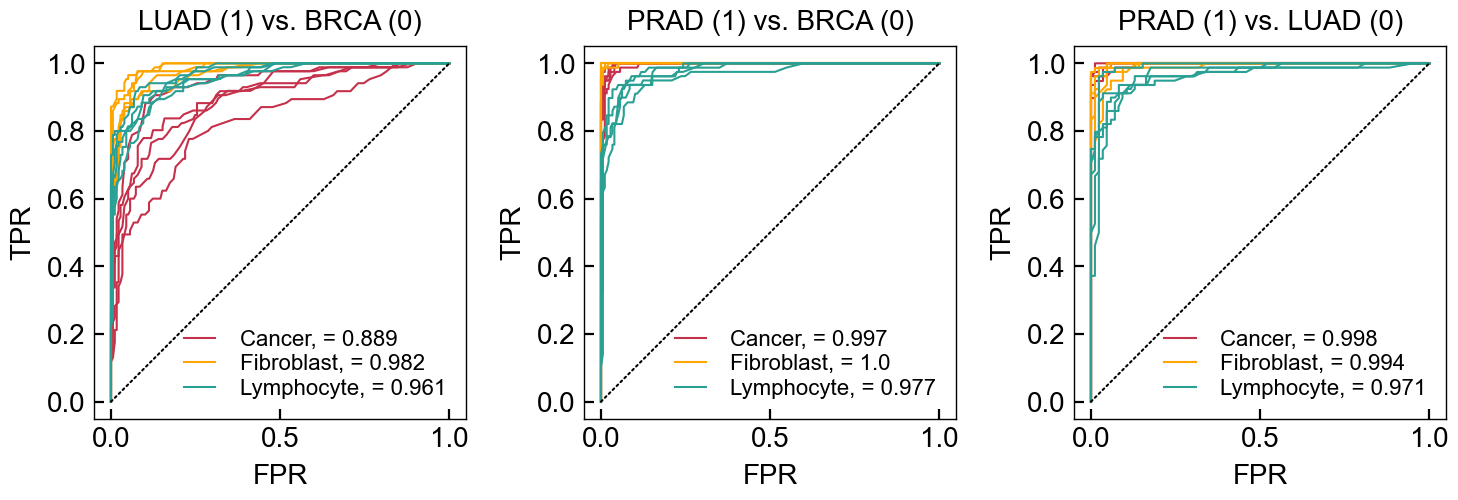

In [6]:
# assemble figure
fig, axs = plt.subplot_mosaic(
    """
    abc
    """,
    figsize=(7.5,3)
)

axs = [axs["a"], axs["b"], axs["c"]]

# for each pairing of cancer types
for pi, keyp in enumerate(group_pairings.keys()):
    
    # find results
    results = full_results[keyp]
    ax = axs[pi]
    
    # plot each dataset
    for di, keyd in enumerate(cell_nuhif_groups.keys()):
        ress = results[keyd]
        aurocs = [resi["auc"] for resi in ress]
        for ri, resi in enumerate(ress):
            if ri==0:
                ax.plot(resi["fpr"], resi["tpr"], color=palette[di], 
                        label=f"{keyd}, = {np.round(np.mean(aurocs), 3)}")
            else:
                ax.plot(resi["fpr"], resi["tpr"], color=palette[di])


    ax.plot([0,1], [0,1], ls=":", color="k")
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.legend(fontsize=8)
    ax.set_aspect("equal")
    ax.set_title(keyp)
plt.tight_layout()
# plt.savefig("figures/result-1/roc-curves.svg")